In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, classification_report

In [ ]:
dfJamur = pd.read_csv('mushrooms.csv')

# Lakukan EDA
print(dfJamur.isnull().sum())
dfJamur.info()

features = list(dfJamur.columns)
features.remove('class')

dfJamur_dummies = pd.get_dummies(dfJamur, columns=features)
dfJamur_dummies['class_code'] = dfJamur_dummies['class'].apply(lambda x: 1 if x == 'p' else 0)
dummyVariables = list(dfJamur_dummies.columns)
dummyVariables.remove('class')
dummyVariables.remove('class_code')

# Train & Test Split data
x_train, x_test, y_train, y_test = train_test_split(
    dfJamur_dummies[dummyVariables], dfJamur_dummies['class_code'], random_state=42, stratify=dfJamur_dummies['class_code'], test_size=.25)    # gunakan stratify agar proporsi jamur beracun & tidak sama di dataset training dan testing

# Hyperparameter Tuning
# logModel = LogisticRegression()
# penalty = ['l1', 'l2', 'elasticnet', 'none']
# solver = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
# max_iter = [10, 100, 1000, 10000]

# parameter_grid = {'penalty': penalty, 'solver': solver, 'max_iter': max_iter} 

# modelGrid = GridSearchCV(logModel, parameter_grid, cv=6)
# modelGrid.fit(x_train, y_train)
# print(modelGrid.best_params_)                                  

# Hasil hyperparameter tuning = {'max_iter': 10, 'penalty': 'none', 'solver': 'newton-cg'}

In [46]:
# Training model menggunakan best parameters
logModelBest = LogisticRegression(max_iter=10, penalty='none', solver='newton-cg')
logModelBest.fit(x_train, y_train)

# Aplikasikan model ke dataset testing
y_test_pred = logModelBest.predict(x_test)

accuracy_testing = accuracy_score(y_test, y_test_pred)
balancedAccuracy_testing = balanced_accuracy_score(y_test, y_test_pred)
precision_testing = precision_score(y_test, y_test_pred)
recall_testing = recall_score(y_test, y_test_pred)
f1_testing = f1_score(y_test, y_test_pred)

print(accuracy_testing, balancedAccuracy_testing, precision_testing, recall_testing, f1_testing)

# Aplikasikan model ke seluruh dataset
y_all_pred = logModelBest.predict(dfJamur_dummies[dummyVariables])

accuracy_all = accuracy_score(dfJamur_dummies['class_code'], y_all_pred)
balancedAccuracy_all = balanced_accuracy_score(dfJamur_dummies['class_code'], y_all_pred)
precision_all = precision_score(dfJamur_dummies['class_code'], y_all_pred)
recall_all = recall_score(dfJamur_dummies['class_code'], y_all_pred)
f1_all = f1_score(dfJamur_dummies['class_code'], y_all_pred)

print(accuracy_all, balancedAccuracy_all, precision_all, recall_all, f1_all)

1.0 1.0 1.0 1.0 1.0
1.0 1.0 1.0 1.0 1.0


c:\users\luthf\appdata\local\programs\python\python38\lib\site-packages\sklearn\utils\optimize.py:211: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn("newton-cg failed to converge. Increase the "


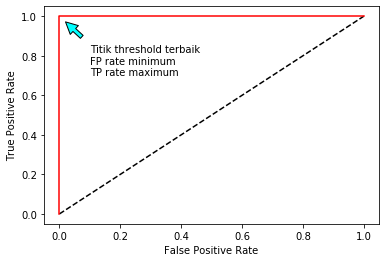

0.9654594322234757 1.0


In [49]:
# ROC AUC CURVE 
# Note: model diaplikasikan ke semua dataset, tidak hanya testing dataset (kebetulan dalam kasus ini skor metrics-nya sama semua)

# Hitung proba score
y_all_proba = logModelBest.predict_proba(dfJamur_dummies[dummyVariables])
y_all_proba_beracun = y_all_proba[:,1]
y_all_proba_edible = y_all_proba[:,0]

fpr, tpr, thresholds = roc_curve(y_all_pred, y_all_proba_beracun)
confusionMatrix = confusion_matrix(dfJamur_dummies['class_code'], y_all_pred, labels=[1,0])
tp, fn, fp, tn = confusionMatrix.reshape(-1,)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.annotate('Titik threshold terbaik\nFP rate minimum\nTP rate maximum', 
            xy=(0, 1), xytext=(.1, .7), arrowprops=dict(facecolor='cyan', shrink=.2))
plt.show()

bestThreshold = thresholds[np.argmax(tpr)]                                       # threshold yang akan menghasilkan tp rate tertinggi
areaUnderCurve = roc_auc_score(y_all_pred, y_all_proba_beracun) 

print(bestThreshold, areaUnderCurve)

In [50]:
# Cek hasil dalam bentuk dataframe

dfJamur_dummies['proba_1'] = y_all_proba_beracun
dfJamur_dummies['proba_0'] = y_all_proba_edible
dfJamur_dummies['y_pred'] = y_all_pred

dfResult = dfJamur_dummies[['class', 'class_code', 'y_pred', 'proba_1', 'proba_0', ]]
dfResult

,class,class_code,y_pred,proba_1,proba_0
0,p,1,1,9.997097e-01,0.000290
1,e,0,0,9.894151e-07,0.999999
2,e,0,0,1.740410e-05,0.999983
3,p,1,1,9.999601e-01,0.000040
4,e,0,0,8.630852e-11,1.000000
...,...,...,...,...,...
8119,e,0,0,5.817868e-05,0.999942
8120,e,0,0,2.282971e-06,0.999998
8121,e,0,0,1.675895e-05,0.999983
8122,p,1,1,9.999824e-01,0.000018
